<a href="https://colab.research.google.com/github/naufalihsan/tesseract/blob/master/Text_Predicting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np

In [3]:
from google.colab import files

uploaded = files.upload()

## Read Dataset

In [0]:
df = pd.read_csv('train.csv')

In [4]:
df.head()

,Unnamed: 0,entity,category
0,0,Mutia Maryati,name
1,1,Padmi Susanti M.Farm,name
2,2,Karen Ayu Nuraini,name
3,3,Bagus Pangestu S.E.,name
4,4,Violet Halimah,name


## Text Cleaning

- remove punctuation
- make lowercase

In [0]:
def primary_name(names):
  names = names.replace('.',' ').split(" ")
  thres = min(3,len(names))
  if len(names[thres-1]) == 1:
    thres -= 1
  return " ".join(names[:thres]).lower()

In [0]:
train = df.copy()
primary_name = train.query('category == "name"')['entity'].apply(lambda x : primary_name(x))

In [0]:
frame = { 'entity': primary_name, 'category': 'name' } 
result = pd.DataFrame(frame) 

In [0]:
def primary_address(address):
  address = address.strip().replace('.',' ').replace(',',' ').replace('-',' ').split(" ")
  if address[0] == 'Jr' or address[0] == 'Jln':
    address[0] = 'jl'
  elif address[0] == 'Dk':
    address[0] = 'dsn'
  elif address[0] == 'Ds':
    address[0] = 'jl'
  elif address[0] == 'Kpg' or address[0] == 'Ki':
    address[0] = 'jl'
  thres = len(address) - 3
  return " ".join(address[:thres])

In [0]:
primary_address = train.query('category == "address"')['entity'].apply(lambda y: primary_address(y))

In [0]:
frame = { 'entity': primary_address, 'category': 'address' } 
result2 = pd.DataFrame(frame)

In [67]:
result3 = train.query('category == "ttl"')
result3['entity'] = result3.loc[:,'entity'].apply(lambda z : z.replace('-',' ')) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [68]:
result3.head()

,Unnamed: 0,entity,category
489,0,Konawe Utara 02 11 1969,ttl
490,1,Wajo 19 10 2000,ttl
491,2,Surakarta 29 11 1976,ttl
492,3,Magetan 17 11 1976,ttl
493,4,Pesisir Barat 05 07 1971,ttl


In [0]:
result = result.append(result2,sort=False, ignore_index=True)
result = result.append(result3,sort=False, ignore_index=True)

In [70]:
display(result.loc[:,'entity':'category'].head())
display(result.loc[:,'entity':'category'].tail())

,entity,category
0,mutia maryati,name
1,padmi susanti,name
2,karen ayu nuraini,name
3,bagus pangestu,name
4,violet halimah,name


,entity,category
2440,Sragen 25 02 1991,ttl
2441,Sigi 31 08 1993,ttl
2442,Aceh Tenggara 01 04 1956,ttl
2443,Banggai Kepulauan 25 04 1963,ttl
2444,Probolinggo 06 01 1961,ttl


In [0]:
# from google.colab import files

# result.to_csv('new_train.csv', index = False, header=True)
# files.download('new_train.csv')

## Building model

- build model to classify entity to its category

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(min_df = 0)
X_train_counts = count_vect.fit_transform(result['entity'])

In [0]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [0]:
from sklearn.preprocessing import LabelEncoder

# creating mapping from unique label texts to unique integers
# note this can be re-used to encode and decode the labels after as well

encoder = LabelEncoder()
target = encoder.fit_transform(result['category'])

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, target, test_size = 0.20, random_state = 21)

In [92]:
datas = ['Bahy Helmi Hartoyo',
         'Jakarta  21 01 1989',
         'Jl Masjid Utara']
X_new_counts = count_vect.transform(datas)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

cheatsheet = dict(zip(encoder.transform(encoder.classes_), encoder.classes_))

print(cheatsheet)

{0: 'address', 1: 'name', 2: 'ttl'}


In [93]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Evaluation model LogisticRegression")
print("Accuracy:", score)

Evaluation model LogisticRegression
Accuracy: 1.0


In [94]:
predicted = classifier.predict(X_new_tfidf)

print('Evaluation Test')
for doc, category in zip(datas, predicted):
    print('Entity : {} => Predict type : {}'.format(doc, cheatsheet[category]))

Evaluation Test
Entity : Bahy Helmi Hartoyo => Predict type : name
Entity : Jakarta  21 01 1989 => Predict type : ttl
Entity : Jl Masjid Utara => Predict type : address


In [78]:
from sklearn.ensemble import GradientBoostingClassifier

learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(
        n_estimators = 100, learning_rate = learning_rate,
        max_depth = 2, random_state = 21)
    gb.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test, y_test)))

Learning rate:  0.05
Accuracy score (training): 1.000
Accuracy score (validation): 1.000
Learning rate:  0.1
Accuracy score (training): 1.000
Accuracy score (validation): 1.000
Learning rate:  0.25
Accuracy score (training): 1.000
Accuracy score (validation): 1.000
Learning rate:  0.5
Accuracy score (training): 1.000
Accuracy score (validation): 1.000
Learning rate:  0.75
Accuracy score (training): 1.000
Accuracy score (validation): 1.000
Learning rate:  1
Accuracy score (training): 1.000
Accuracy score (validation): 1.000


In [0]:
from sklearn.naive_bayes import MultinomialNB


clf = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=1,
    max_depth=2,
    random_state=21).fit(X_train, y_train)

In [80]:
score = clf.score(X_test, y_test)

print("Evaluation model GradientBoostingClassifier")
print("Accuracy :", score)

Evaluation model GradientBoostingClassifier
Accuracy : 1.0


In [95]:
predicted = clf.predict(X_new_tfidf)

print('Evaluation Test')
for doc, category in zip(datas, predicted):
    print('Entity : {} => Predict type : {}'.format(doc, cheatsheet[category]))

Evaluation Test
Entity : Bahy Helmi Hartoyo => Predict type : name
Entity : Jakarta  21 01 1989 => Predict type : ttl
Entity : Jl Masjid Utara => Predict type : name


Text(0.5, 1.0, 'Confusion Matrix')

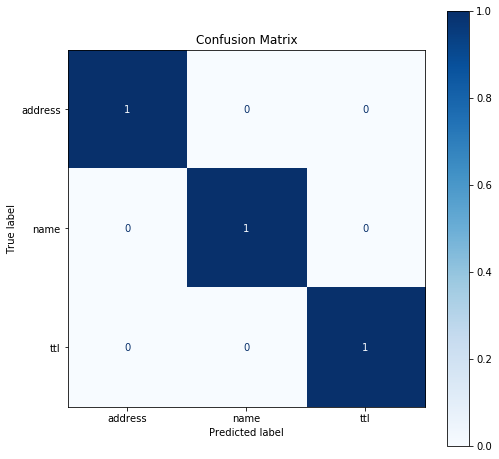

In [96]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib as plt

disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels= encoder.classes_,
                                 cmap=plt.cm.Blues,normalize='pred')
disp.figure_.set_size_inches(8,8)
disp.ax_.set_title('Confusion Matrix')

## Using Keras Model

In [98]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

TensorFlow is already loaded. Please restart the runtime to change versions.


In [99]:
from tensorflow.keras.preprocessing.text import Tokenizer

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000

# Max number of words in each entity
MAX_SEQUENCE_LENGTH = 5

# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower = True)
tokenizer.fit_on_texts(result['entity'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 1646 unique tokens.


In [100]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


X = tokenizer.texts_to_sequences(result['entity'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', X.shape)

Shape of data tensor: (2445, 5)


In [101]:
Y = pd.get_dummies(result['category']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (2445, 3)


In [102]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, random_state = 21)
print('Train {}'.format(X_train.shape[0]))
print('Test {}'.format(X_test.shape[0]))

Train 2078
Test 367


In [103]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [104]:
from tensorflow.keras.callbacks import EarlyStopping

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, Y_test),
                    callbacks=[
                      EarlyStopping(monitor='val_loss',
                                    patience=3,
                                    min_delta=0.0001)
                    ])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 2078 samples, validate on 367 samples
Epoch 1/5
2078/2078 [==============================] - 3s 2ms/sample - loss: 0.8791 - acc: 0.8330 - val_loss: 0.3481 - val_acc: 1.0000
Epoch 2/5
2078/2078 [==============================] - 2s 1ms/sample - loss: 0.1061 - acc: 0.9986 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 3/5
2078/2078 [==============================] - 2s 1ms/sample - loss: 0.0018 - acc: 1.0000 - val_loss: 7.0336e-04 - val_acc: 1.0000
Epoch 4/5
2078/2078 [==============================] - 2s 1ms/sample - loss: 6.9175e-04 - acc: 1.0000 - val_loss: 4.1155e-04 - val_acc: 1.0000
Epoch 5/5
2078/2078 [==============================] - 2s 1ms/sample - loss: 4.2283e-04 - acc: 1.0000 - val_loss: 2.8639e-04 - val_acc: 1.0000


In [105]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

367/367 [==============================] - 0s 119us/sample - loss: 2.8639e-04 - acc: 1.0000
Test set
  Loss: 0.000
  Accuracy: 1.000


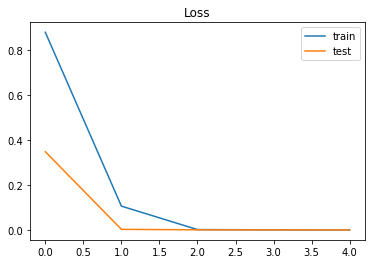

In [106]:
import matplotlib.pyplot as plt 

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

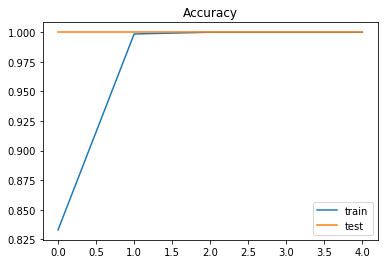

In [108]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

In [109]:
new_complaint = ['Bandung 17 08 1994']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['address','name','ttl']
print(pred, labels[np.argmax(pred)])

[[3.0377787e-04 1.9302935e-03 9.9776590e-01]] ttl


In [110]:
new_complaint = ['Jln Senayan GG BB No 25']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['address','name','ttl']
print(pred, labels[np.argmax(pred)])

[[0.00148812 0.99412006 0.00439179]] name


In [111]:
new_complaint = ['Naufal Ihsan Pratama']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['address','name','ttl']
print(pred, labels[np.argmax(pred)])

[[7.1725764e-05 9.9982280e-01 1.0543930e-04]] name
